In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

file_path = "preprocessed_air_quality.csv"
df = pd.read_csv(file_path)

In [3]:
# Convert Date to datetime format
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [5]:
# Handle missing values
df = df.fillna(df.median(numeric_only=True))

# Feature Engineering
if 'Date' in df.columns:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

# Categorize AQI into levels if AQI column exists
def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

if 'AQI' in df.columns:
    df['AQI_Level'] = df['AQI'].apply(categorize_aqi)

In [6]:
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col not in ['AQI_Level']:
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))


In [10]:
X_reg = df_encoded.drop(columns=['Date', 'AQI', 'AQI_Level'], errors='ignore')
y_reg = df_encoded['AQI']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train_reg_scaled, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg_scaled)

print("\n->Regression Results")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.2f}")



->Regression Results
Mean Squared Error (MSE): 6564.91
R² Score: -0.03


In [9]:
X_clf = df_encoded.drop(columns=['Date', 'AQI', 'AQI_Level'], errors='ignore')
y_clf = df['AQI_Level']

label_encoder = LabelEncoder()
y_clf_encoded = label_encoder.fit_transform(y_clf)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf_encoded, test_size=0.2, random_state=42
)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

clf_model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)
clf_model.fit(X_train_clf_scaled, y_train_clf)
y_pred_clf = clf_model.predict(X_test_clf_scaled)

print("\n->Classification Results")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.2f}")
print("Classification Report:\n", classification_report(
    y_test_clf, y_pred_clf, target_names=label_encoder.classes_, zero_division=0
))



->Classification Results
Accuracy: 0.37
Classification Report:
                          precision    recall  f1-score   support

                   Good       0.00      0.00      0.00        63
               Moderate       0.39      0.05      0.09       142
              Unhealthy       0.06      0.01      0.02       114
Unhealthy for Sensitive       0.19      0.05      0.07       130
         Very Unhealthy       0.38      0.90      0.54       283

               accuracy                           0.37       732
              macro avg       0.21      0.20      0.14       732
           weighted avg       0.27      0.37      0.24       732



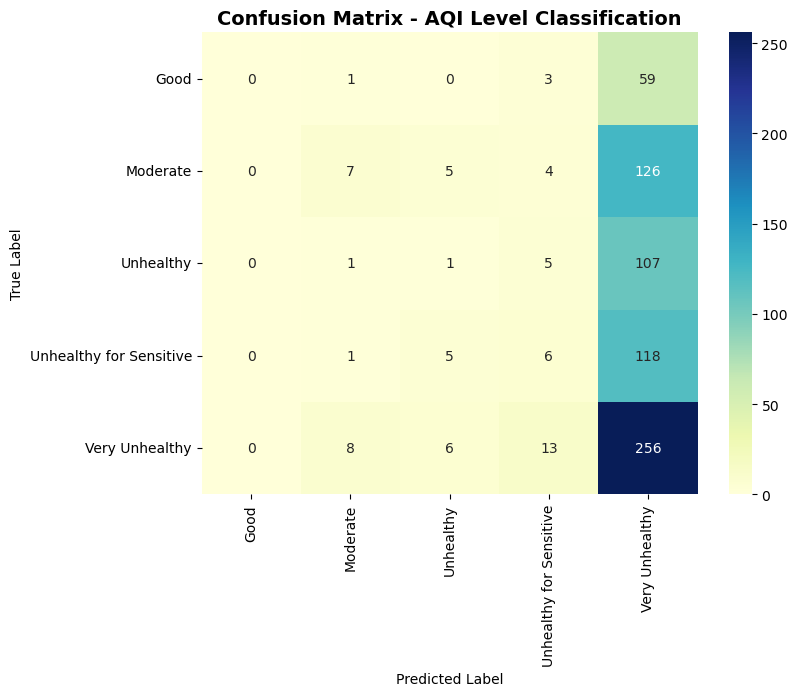

In [11]:
#Confusion Matrix (Classification)
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - AQI Level Classification", fontsize=14, weight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

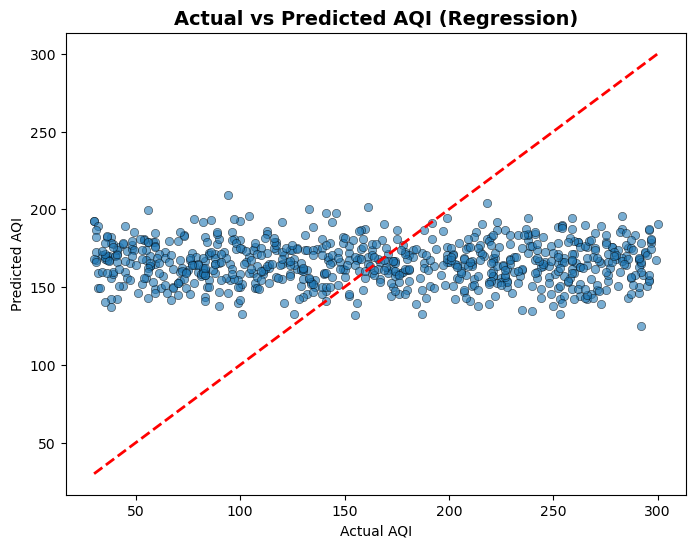

In [12]:
# Actual vs Predicted (Regression)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.6, edgecolor='k')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.title("Actual vs Predicted AQI (Regression)", fontsize=14, weight='bold')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

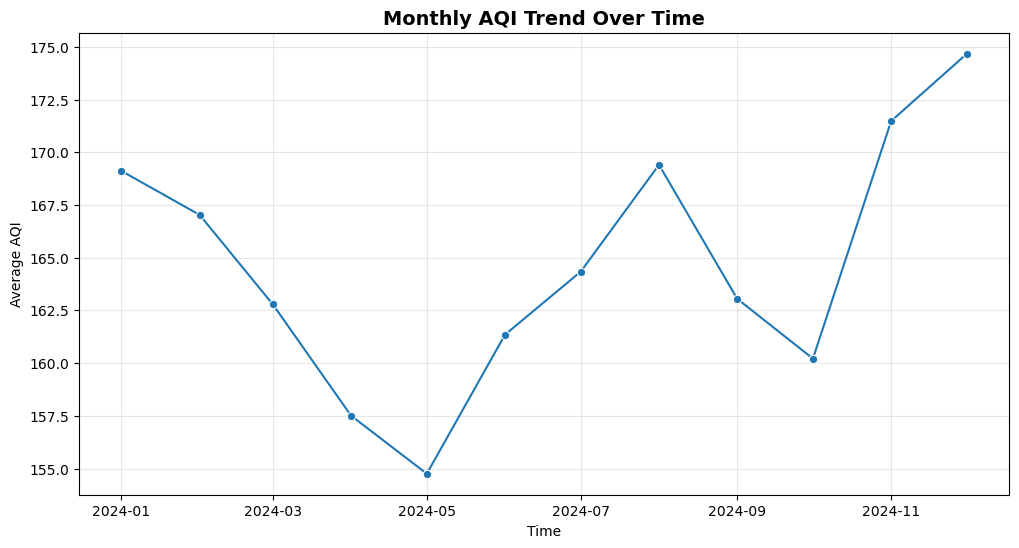

In [14]:
# AQI Trend Over Time
if 'Date' in df.columns:
    plt.figure(figsize=(12,6))
    monthly_trend = df.groupby(['Year','Month'])['AQI'].mean().reset_index()
    monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Year','Month']].assign(DAY=1))
    sns.lineplot(x='Date', y='AQI', data=monthly_trend, marker='o')
    plt.title("Monthly AQI Trend Over Time", fontsize=14, weight='bold')
    plt.xlabel("Time")
    plt.ylabel("Average AQI")
    plt.grid(True, alpha=0.3)
    plt.show()